# Interpretability of autoencoder latent space for passengers demand-sensitive planning on high-speed railways (IWANN 2023)


In [23]:
import datetime
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import tensorflow as tf

from feature_engine.creation import CyclicalFeatures
from IPython.display import display
from nltk.corpus import wordnet
from numpy.random import seed
from scipy import spatial
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from typing import Dict, List, Tuple

from src.robin.supply.entities import Supply

SEED = 15

seed(SEED)  # Set numpy random seed
random.seed(SEED)  # Set random seed

SAVE_PATH = '../reports/figures/ae_interpretability/'

if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

In [3]:
# Download wordnet if not already downloaded
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/uclm/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
def get_paths_from_supply(path_config_supply: str = '../configs/test_case/supply_data.yml') -> List[List[str]]:
    """
    Get the paths of a supply

    Args:
        path_config_supply (str, optional): Path to the supply config file. Defaults to '../configs/test_case/supply_data.yml'.

    Returns:
        List[List[str]]: List of paths
    """
    supply = Supply.from_yaml(path_config_supply)

    # Get set of corridors
    corridors = []
    for service in supply.services:
        if service.line.corridor not in corridors:
            corridors.append(service.line.corridor)

    # Get set of paths
    paths = []
    for corridor in corridors:
        for path in corridor.paths:
            if path not in paths:
                paths.append(path)

    # Parse paths of Station objects to paths of station mame
    paths = [[station.name.replace("-", " ").split(" ")[0].lower() for station in path] for path in paths]
    return paths

paths = get_paths_from_supply()
print(paths)

[['madrid', 'guadalajara', 'calatayud', 'zaragoza', 'lleida', 'tarragona', 'barcelona', 'girona', 'figueres']]


In [5]:
def get_random_pair(paths: list[list]) -> Tuple[str, str]:
    """
    Get a random pair of stations from a path

    Args:
        paths (list[list]): List of stations

    Returns:
        Tuple[str, str]: Tuple with the origin and destination stations
    """
    random_path = random.choice(paths)  # Choose a random path

    origin_index = random.randint(0, len(random_path) - 2)  # Choose a random origin station
    destination_index = random.randint(origin_index + 1, len(random_path) - 1)  # Choose a random destination station

    origin_station = random_path[origin_index]
    destination_station = random_path[destination_index]
    return origin_station, destination_station

In [6]:
def get_renfe_station_id(adif_id: str, stations_df: pd.DataFrame) -> str:
    """
    Returns the Station name given the Adif station id.

    Args:
        adif_id (str): Adif station id.
        stations_df (pd.DataFrame): Dataframe with the stations' information.

    Returns:
        str: Station name.
    """
    station_name = stations_df[stations_df['stop_id'] == adif_id]['stop_name'].values[0]
    station_name = station_name.replace("-", " ").split(" ")[0].lower()
    return station_name

stations_csv_path = f'../data/renfe/renfe_stations.csv'
stations_df = pd.read_csv(stations_csv_path, dtype={'stop_id': str, 'renfe_id': str})

In [7]:
def simulate_passengers_data(paths: list,
                             user_patterns: list,
                             n_passengers: int = 10000,
                             seed: int = 42
    ) -> pd.DataFrame:
    # Set random state
    random.seed(seed)

    pairs = []
    for _ in range(n_passengers):
        pairs.append(get_random_pair(paths))

    df = pd.DataFrame(pairs, columns=['origin', 'destination'])
    df['user_pattern'] = [random.choice(user_patterns) for _ in range(n_passengers)]

    random_days = lambda: random.randint(0, 365*10)
    random_hours = lambda: random.randint(0, 24)
    random_minutes = lambda: random.randint(0,60)

    random_timedelta = lambda: datetime.timedelta(days=random_days(), hours=random_hours(), minutes=random_minutes())
    df['arrival_date'] = [datetime.datetime(2021, 1, 1) + random_timedelta() for _ in range(n_passengers)]
    df['week_day'] = [date.strftime('%A').lower() for date in df['arrival_date']]
    df['month'] = [date.strftime('%B').lower() for date in df['arrival_date']]
    df['time'] = [date.time() for date in df['arrival_date']]
    return df

user_patterns = ("business", "student", "tourist")
df = simulate_passengers_data(paths, user_patterns, n_passengers=10000)

display(df.head())

,origin,destination,user_pattern,arrival_date,week_day,month,time
0,madrid,tarragona,tourist,2027-05-03 14:39:00,monday,may,14:39:00
1,zaragoza,tarragona,business,2028-01-04 23:52:00,tuesday,january,23:52:00
2,guadalajara,barcelona,business,2027-08-13 01:46:00,friday,august,01:46:00
3,madrid,guadalajara,student,2028-08-30 07:48:00,wednesday,august,07:48:00
4,zaragoza,tarragona,student,2029-08-27 04:15:00,monday,august,04:15:00


In [8]:
class AutoencoderEmbedding:
    """
    Class to get the embedding of a dataframe to be used as input of an autoencoder

    Attributes:
        df (pd.DataFrame): Dataframe with the data to be embedded
        df_embedding (pd.DataFrame): Dataframe with the embedding.
        embedding_dim (int, optional): Embedding dimension. Defaults to 50.
        embedding_dict (dict): Dictionary with the embedding.
        scaler (MinMaxScaler): Scaler to normalize the data.
        cyclical (CyclicalFeatures): Cyclical features transformer.
        df_time (pd.DataFrame): Dataframe with the time embedding.
        input_arrays (list[np.array]): List of arrays with the embedded input data.
    """
    def __init__(self, df: pd.DataFrame, embedding_dim: int = 50, noise: bool = True):
        """
        Constructor method

        Args:
            df (pd.DataFrame): Dataframe with the data to be embedded
            embedding_dim (int, optional): Embedding dimension. Defaults to 50.
        """
        self.df = df
        self.noise = noise
        self.embedding_dim = embedding_dim
        self.scaler = MinMaxScaler()
        self.cyclical = CyclicalFeatures(variables=['time'], drop_original=True)
        if self.noise:
            self.df_noisy = self._get_noisy_df()

        df_bag_words = pd.concat([self.df_noisy, self.df], ignore_index=True) if self.noise else self.df
        words_set = set(df_bag_words[['origin', 'destination', 'user_pattern', 'week_day', 'month']].values.flatten())
        self.word_index = {word: index for index, word in enumerate(words_set)}
        self.embedding_dict = self._get_embedding_dict()

        if self.noise:
            self.df_embedding_noisy = self._get_embedding_df(self.df_noisy)
            self.words_noisy_embedding = self._get_words_embedding(self.df_embedding_noisy)
            self.time_noisy_embedding = self._get_time_embedding(self.df_embedding_noisy)
        self.df_embedding = self._get_embedding_df(self.df)
        self.words_embeddings = self._get_words_embedding(self.df_embedding)
        self.time_embedding = self._get_time_embedding(self.df_embedding)

    def _get_words_embedding(self, df: pd.DataFrame) -> np.array:
        """
        Get the words embedding.

        Args:
            df (pd.DataFrame, optional): Dataframe with the data to be embedded. Defaults to None.

        Returns:
            np.array: Array with the words embedding.
        """
        input_data = df[['origin', 'destination', 'user_pattern', 'week_day', 'month']].values.tolist()
        return np.array([np.asarray(row, dtype=np.float32) for row in input_data])

    def _get_time_embedding(self, df: pd.DataFrame) -> np.array:
        """
        Get the time embedding.

        Args:
            df (pd.DataFrame, optional): Dataframe with the data to be embedded.

        Returns:
            np.array: Array with the time embedding.
        """
        input_data = df[['time']].values.tolist()
        return np.array([np.asarray(row, dtype=np.float32) for row in input_data])

    def _get_embedding_dict(self) -> Dict[str, np.array]:
        """
        Get the words embedding dictionary

        Returns:
            Dict[str, np.array]: Dictionary with the embedding.
        """
        embeddings_index = {}
        f = open(os.path.join('../data/pretrained/glove6B/glove.6B.50d.txt'))

        # Read GloVe embeddings
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype=np.float32)
            embeddings_index[word] = coefs
        f.close()

        # Create embedding matrix
        embedding_matrix = np.zeros((len(self.word_index) + 1, self.embedding_dim))
        embedding_dict = {}
        for word, i in self.word_index.items():
            embedding_vector = embeddings_index.get(word, np.zeros(self.embedding_dim))
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                embedding_dict[word] = embedding_vector

        return embedding_dict

    def decode_time_embedding(self, time_embedding: np.array) -> datetime.time:
        """
        Decode the time embedding

        Args:
            time_embedding (np.array): Time embedding

        Returns:
            datetime.time: Time
        """
        total_minutes = self.scaler.inverse_transform(time_embedding)
        hours = int(total_minutes / 60)
        minutes = int(total_minutes % 60)
        time = datetime.time(hour=hours, minute=minutes)

        return time

    def get_word_syn(self, word: str) -> str:
        """
        Get a random synonym of a word

        Args:
            word (str): Word to get the synonym from

        Returns:
            str: Synonym of the word
        """
        word_synset = wordnet.synsets(word)
        if len(word_synset) > 0:
            station_synset = word_synset[0]
            station_lemmas = station_synset.lemmas()
            if len(station_lemmas) > 0:
                word_lemma = random.choice(station_lemmas)
                return word_lemma.name().lower()

        return word

    def _get_noisy_df(self, p: float = 0.2) -> pd.DataFrame:
        """
        Get the noisy embedding dataframe by replacing some of the words with synonyms

        Returns:
            pd.DataFrame: Noisy embedding dataframe.
        """
        df_noisy = self.df.copy()
        df_noisy['origin'] = df_noisy['origin'].apply(lambda x: self.get_word_syn(x) if random.random() < p else x)
        df_noisy['destination'] = df_noisy['destination'].apply(lambda x: self.get_word_syn(x) if random.random() < p else x)
        df_noisy['user_pattern'] = df_noisy['user_pattern'].apply(lambda x: self.get_word_syn(x) if random.random() < p else x)
        df_noisy['week_day'] = df_noisy['week_day'].apply(lambda x: self.get_word_syn(x) if random.random() < p else x)
        df_noisy['month'] = df_noisy['month'].apply(lambda x: self.get_word_syn(x) if random.random() < p else x)

        # Replace time with a similar date (sum random timedelta of minutes in range [-30, 30])
        #df_noisy['time'] = df_noisy['arrival_date'].apply(lambda x: x + datetime.timedelta(minutes=random.randint(-30, 30)) if random.random() < p else x)
        #df_noisy['time'] = df_noisy['time'].apply(lambda x: x.time())

        return df_noisy

    def _get_embedding_df(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Get embedding dataframe.

        Returns:
            pd.DataFrame: Embedding dataframe.
        """
        df_embedding = df.copy()
        df_embedding['origin'] = df_embedding['origin'].apply(lambda x: self.embedding_dict.get(x))
        df_embedding['destination'] = df_embedding['destination'].apply(lambda x: self.embedding_dict.get(x))
        df_embedding['user_pattern'] = df_embedding['user_pattern'].apply(lambda x: self.embedding_dict.get(x))
        df_embedding['week_day'] = df_embedding['week_day'].apply(lambda x: self.embedding_dict.get(x))
        df_embedding['month'] = df_embedding['month'].apply(lambda x: self.embedding_dict.get(x))

        def total_minutes(time: datetime.datetime) -> np.float32:
            total_minutes = (time.hour * 60) + time.minute
            return np.float32(total_minutes)

        df_embedding['time'] = df_embedding['time'].apply(lambda x: total_minutes(x))
        df_embedding['time'] = self.scaler.fit_transform(df_embedding[['time']])

        return df_embedding[['origin', 'destination', 'user_pattern', 'week_day', 'month', 'time']]

In [9]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

EMBEDDING_DIM = 50

print("Train data shape: ", df_train.shape)
print("Test data shape: ", df_test.shape)

train_embedding = AutoencoderEmbedding(df = df_train, embedding_dim=EMBEDDING_DIM)
test_embedding = AutoencoderEmbedding(df = df_test, embedding_dim=EMBEDDING_DIM, noise=False)

print("Header of train data:")
display(train_embedding.df.head())

print("Header of test data:")
display(test_embedding.df.head())

Train data shape:  (7000, 7)
Test data shape:  (3000, 7)
Header of train data:


,origin,destination,user_pattern,arrival_date,week_day,month,time
9069,tarragona,girona,student,2029-02-27 19:38:00,tuesday,february,19:38:00
2603,zaragoza,girona,tourist,2030-08-31 09:54:00,saturday,august,09:54:00
7738,lleida,figueres,tourist,2026-06-20 08:14:00,saturday,june,08:14:00
1579,zaragoza,figueres,student,2021-02-20 00:04:00,saturday,february,00:04:00
5058,zaragoza,lleida,student,2027-01-26 09:35:00,tuesday,january,09:35:00


Header of test data:


,origin,destination,user_pattern,arrival_date,week_day,month,time
6252,zaragoza,lleida,student,2027-06-13 22:10:00,sunday,june,22:10:00
4684,girona,figueres,tourist,2030-06-01 23:10:00,saturday,june,23:10:00
1731,guadalajara,figueres,business,2027-07-16 04:05:00,friday,july,04:05:00
4742,guadalajara,girona,student,2021-01-19 17:26:00,tuesday,january,17:26:00
4521,madrid,figueres,student,2024-05-21 10:39:00,tuesday,may,10:39:00


## Autoencoder model

In [10]:
words_embeddings_shape = (5, EMBEDDING_DIM)
time_embedding_shape = (1,)

SEQUENCE_LENGTH = 5

latent_dim = 5

# Encoder model
input_words = Input(shape=words_embeddings_shape)

conv1 = Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_words)
conv2 = Conv1D(32, kernel_size=3, activation='relu', padding='same')(conv1)
pooling = GlobalMaxPooling1D()(conv2)
flat_layer = Flatten()(pooling)

input_time = Input(shape=time_embedding_shape)
concat_layer = Concatenate(axis=1)([flat_layer, input_time])

encoder = Dense(64)(concat_layer)
encoder = Dense(32)(encoder)

dense1 = Dense(latent_dim, activation='tanh')(encoder)

# Decoder model
decoder_inputs = Input(shape=(latent_dim,))
dense3 = Dense(32)(decoder_inputs)
dense4 = Dense(64)(dense3)

repeat_vector = RepeatVector(6)(Flatten()(dense4))

decoder = Dense(32 * SEQUENCE_LENGTH, activation='relu')(dense4)
decoder = Reshape((SEQUENCE_LENGTH, 32))(decoder)
decoder = Conv1DTranspose(32, kernel_size=3, activation='relu', padding='same')(decoder)
decoder = Conv1DTranspose(64, kernel_size=3, activation='relu', padding='same')(decoder)
decoder_words = Conv1DTranspose(EMBEDDING_DIM, kernel_size=3, padding='same')(decoder)

decoder_time = Dense(1)(dense4)

encoder_model = Model(inputs=[input_words, input_time], outputs=dense1)
encoder_model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

decoder_model = Model(inputs=decoder_inputs, outputs=[decoder_words, decoder_time])
decoder_model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

decoded_words, decoded_time = decoder_model(dense1)
model = Model(inputs=[input_words, input_time], outputs=[decoded_words, decoded_time])

model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])
model.summary()

2023-06-01 10:28:43.020538: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 50)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 5, 64)        9664        ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 5, 32)        6176        ['conv1d[0][0]']                 
                                                                                                  
 global_max_pooling1d (GlobalMa  (None, 32)          0           ['conv1d_1[0][0]']               
 xPooling1D)                                                                                

In [11]:
history = model.fit(x = [train_embedding.words_embeddings, train_embedding.time_embedding],
                    y = [train_embedding.words_embeddings, train_embedding.time_embedding],
                    epochs=20,
                    batch_size=32,
                    verbose=1)

Epoch 1/20
219/219 [==============================] - 2s 3ms/step - loss: 0.1905 - model_1_loss: 0.1711 - model_1_1_loss: 0.0194 - model_1_mean_squared_error: 0.1711 - model_1_1_mean_squared_error: 0.0194
Epoch 2/20
219/219 [==============================] - 1s 4ms/step - loss: 0.1014 - model_1_loss: 0.1007 - model_1_1_loss: 7.1432e-04 - model_1_mean_squared_error: 0.1007 - model_1_1_mean_squared_error: 7.1432e-04
Epoch 3/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0868 - model_1_loss: 0.0865 - model_1_1_loss: 3.3200e-04 - model_1_mean_squared_error: 0.0865 - model_1_1_mean_squared_error: 3.3200e-04
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0722 - model_1_loss: 0.0718 - model_1_1_loss: 4.3649e-04 - model_1_mean_squared_error: 0.0718 - model_1_1_mean_squared_error: 4.3649e-04
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0509 - model_1_loss: 0.0507 - model_1_1_loss: 2.2590e-04 - model_1_mean_squared_

In [12]:
history.history.keys()

dict_keys(['loss', 'model_1_loss', 'model_1_1_loss', 'model_1_mean_squared_error', 'model_1_1_mean_squared_error'])

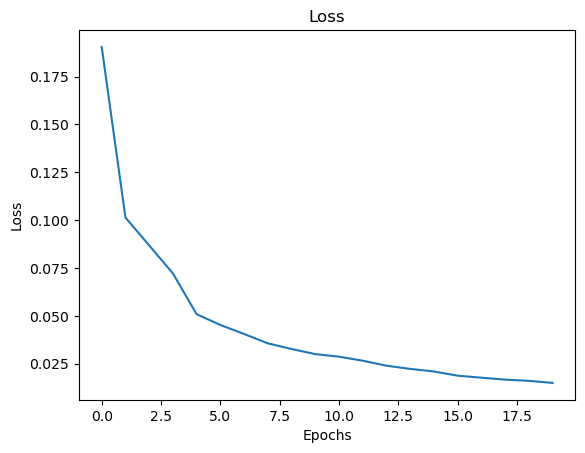

In [13]:
# Plot history loss
plt.plot(history.history['loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [14]:
# Evaluate model
score = model.evaluate(x=[test_embedding.words_embeddings, test_embedding.time_embedding],
                       y=[test_embedding.words_embeddings, test_embedding.time_embedding],
                       verbose=1)

94/94 [==============================] - 0s 2ms/step - loss: 0.0139 - model_1_loss: 0.0137 - model_1_1_loss: 1.6291e-04 - model_1_mean_squared_error: 0.0137 - model_1_1_mean_squared_error: 1.6291e-04


## Make predictions

In [15]:
def find_closest_embeddings(embedding, emb):
    return sorted(emb.keys(), key=lambda word: spatial.distance.euclidean(emb[word], embedding))[0]

In [17]:
random_index = np.random.randint(0, test_embedding.df.shape[0])

random_words_embedding = test_embedding.words_embeddings[random_index:random_index+1]
random_time_embedding = test_embedding.time_embedding[random_index:random_index+1]

print("Input - Random passenger data: ")
print(test_embedding.df.iloc[random_index])

prediction = model.predict(x = [random_words_embedding, random_time_embedding])

print("Output - Passenger reconstruction: ")
decoded_words = [find_closest_embeddings(word_vector, test_embedding.embedding_dict) for word_vector in prediction[0][0]]
print(decoded_words)

print("Time prediction: ")
predicted_time = test_embedding.decode_time_embedding([prediction[1][0]])
print(predicted_time)

Input - Random passenger data: 
origin                     zaragoza
destination                figueres
user_pattern               business
arrival_date    2026-05-04 05:18:00
week_day                     monday
month                           may
time                       05:18:00
Name: 9444, dtype: object
1/1 [==============================] - 0s 50ms/step
Output - Passenger reconstruction: 
['zaragoza', 'figueres', 'business', 'thursday', 'september']
Time prediction: 
05:23:00


## Estudio de la correlación entre factores latentes y la entrada del autoencoder

In [28]:
# Latent space for test data
latent_space = encoder_model.predict(x = [test_embedding.words_embeddings, test_embedding.time_embedding])

94/94 [==============================] - 0s 1ms/step


[]

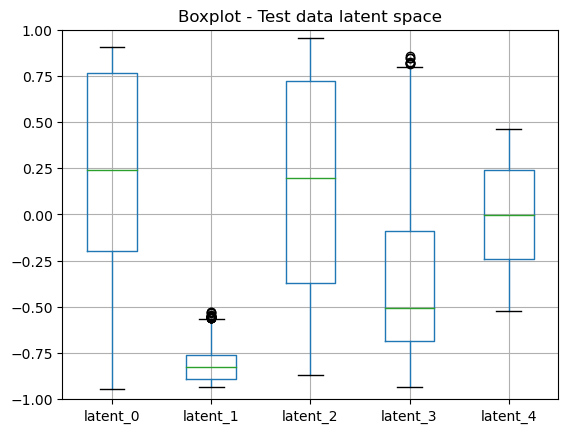

In [29]:
# Box Plot
df_predictions = pd.DataFrame(latent_space, columns = [f"latent_{i}" for i in range(latent_space.shape[1])])

b_plot = df_predictions.boxplot()
plt.ylim(-1, 1)

plt.title("Boxplot - Test data latent space")
plt.savefig(SAVE_PATH + "boxplot_test_data.png", dpi=300)
b_plot.plot()

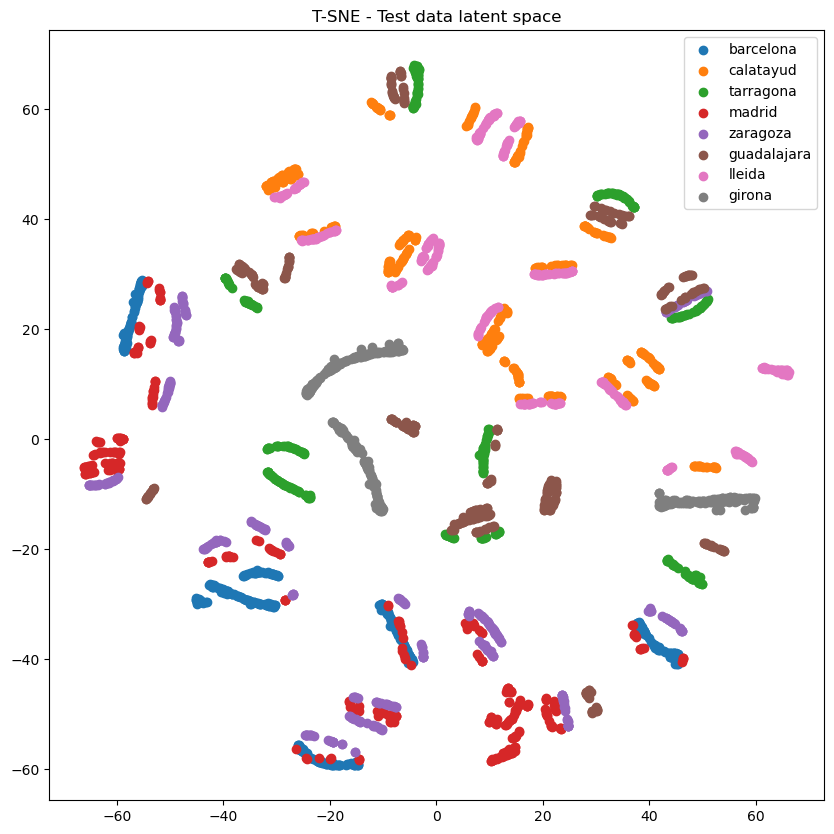

In [30]:
# T-SNE
tsne = TSNE(n_components=2, random_state=15)
tsne_latent_space = tsne.fit_transform(latent_space)

# Scatter plot tsne_latent_space
plt.figure(figsize=(10, 10))
plt.title("T-SNE - Test data latent space")

origin_values = set(test_embedding.df['origin'].values)
for i, origin in enumerate(origin_values):
    plt.scatter(tsne_latent_space[test_embedding.df['origin'] == origin, 0],
                tsne_latent_space[test_embedding.df['origin'] == origin, 1],
                label=origin)
plt.legend()
plt.savefig(SAVE_PATH + "tsne_test_data", dpi=300)
plt.show()

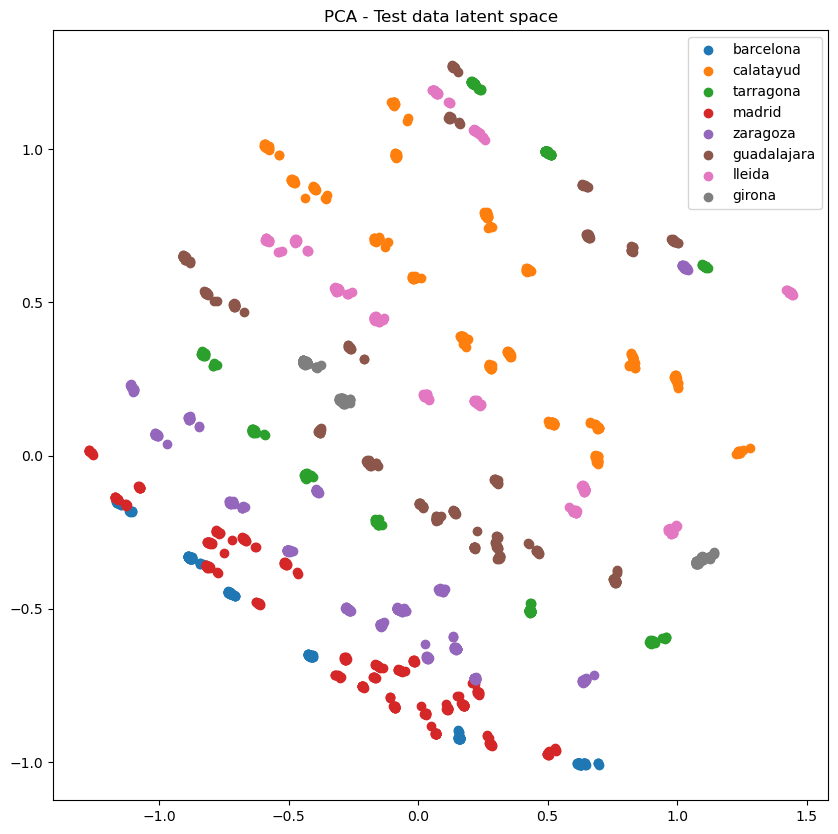

In [31]:
# PCA on latent space to analyze relationship between latent factors and input variables
pca = PCA(n_components=2)
pca_latent_space = pca.fit_transform(latent_space)

# Scatter plot pca_latent_space with legend of origin
plt.figure(figsize=(10, 10))
plt.title("PCA - Test data latent space")

for i, origin in enumerate(origin_values):
    plt.scatter(pca_latent_space[test_embedding.df['origin'] == origin, 0],
                pca_latent_space[test_embedding.df['origin'] == origin, 1],
                label=origin)

plt.legend()
plt.savefig(SAVE_PATH + "pca_test_data", dpi=300)
plt.show()

## Test data analysis with locked columns

In [32]:
def get_locked_dataframe(df: pd.DataFrame,
                         locked_columns: list,
                         seed: int = 18
    ) -> pd.DataFrame:
    """
    Get a dataframe with locked columns (all rows with the same value)

    Args:
        df (pd.DataFrame): Dataframe to lock
        locked_columns (list): List of columns to lock
        seed (int): Random seed

    Returns:
        pd.DataFrame: Locked dataframe
    """
    random.seed(seed)
    df_locked = df.copy()

    for column in locked_columns:
        values = tuple(set(df_locked[column].values))
        locked_value = random.sample(values, 1)[0]
        df_locked[column] = locked_value

    return df_locked

locked_dataframe = get_locked_dataframe(df=test_embedding.df,
                                        locked_columns=['destination', 'user_pattern', 'week_day', 'month', 'time'])

locked_embedding = AutoencoderEmbedding(df=locked_dataframe, embedding_dim=EMBEDDING_DIM)
display(locked_embedding.df.head())

# Get latent space of the locked_embedding
latent_space = encoder_model.predict(x = [locked_embedding.words_embeddings, locked_embedding.time_embedding])

# Get range of values for each latent factor
latent_space_range = pd.DataFrame(latent_space).describe().loc[['min', 'max']]

print("Latent space range: ")
print(latent_space_range)

,origin,destination,user_pattern,arrival_date,week_day,month,time
6252,zaragoza,tarragona,student,2027-06-13 22:10:00,friday,january,15:49:00
4684,girona,tarragona,student,2030-06-01 23:10:00,friday,january,15:49:00
1731,guadalajara,tarragona,student,2027-07-16 04:05:00,friday,january,15:49:00
4742,guadalajara,tarragona,student,2021-01-19 17:26:00,friday,january,15:49:00
4521,madrid,tarragona,student,2024-05-21 10:39:00,friday,january,15:49:00


94/94 [==============================] - 0s 1ms/step
Latent space range: 
            0        1         2         3         4
min -0.357681 -0.81948 -0.839553 -0.525294  0.371028
max  0.831520 -0.68776 -0.692195 -0.319951  0.421359


[]

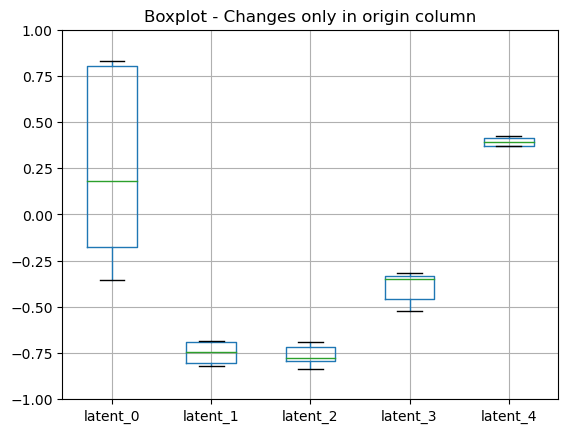

In [34]:
# Cambios en origen
df_predictions = pd.DataFrame(latent_space, columns = [f"latent_{i}" for i in range(latent_space.shape[1])])

b_plot = df_predictions.boxplot()
plt.ylim(-1, 1)

plt.title("Boxplot - Changes only in origin column")
b_plot.plot()

In [44]:
latent_factors_range = []
num_iters = 30

for i in range(1, num_iters+1):
    print(f"Iter {i}...")
    locked_dataframe = get_locked_dataframe(test_embedding.df, locked_columns=['origin', 'destination', 'user_pattern', 'month', 'time'], seed=i)
    locked_embedding = AutoencoderEmbedding(df=locked_dataframe, embedding_dim=EMBEDDING_DIM)
    locked_latent_space = encoder_model.predict(x = [locked_embedding.words_embeddings, locked_embedding.time_embedding], verbose=0)
    latent_factors_range.append(pd.DataFrame(locked_latent_space).describe().loc[['min', 'max']])

Iter 1...
Iter 2...
Iter 3...
Iter 4...
Iter 5...
Iter 6...
Iter 7...
Iter 8...
Iter 9...
Iter 10...
Iter 11...
Iter 12...
Iter 13...
Iter 14...
Iter 15...
Iter 16...
Iter 17...
Iter 18...
Iter 19...
Iter 20...
Iter 21...
Iter 22...
Iter 23...
Iter 24...
Iter 25...
Iter 26...
Iter 27...
Iter 28...
Iter 29...
Iter 30...


In [45]:
latent_factors = [list(zip(*lfr.values)) for lfr in latent_factors_range]

df = pd.DataFrame(latent_factors, columns = [f'latent_{i}' for i in range(len(latent_factors[0]))])
display(df)

,latent_0,latent_1,latent_2,latent_3,latent_4
0,"(0.29889267683029175, 0.30300524830818176)","(-0.832685112953186, -0.8276068568229675)","(0.8321937918663025, 0.8376157879829407)","(0.13633108139038086, 0.1593940109014511)","(0.44763442873954773, 0.45009246468544006)"
1,"(0.8794580698013306, 0.8812985420227051)","(-0.8176734447479248, -0.7918439507484436)","(-0.5759715437889099, -0.5697141885757446)","(-0.29043424129486084, -0.2686521112918854)","(0.4002438187599182, 0.40846556425094604)"
2,"(0.8665716052055359, 0.8677504062652588)","(-0.8829813003540039, -0.8729717135429382)","(0.6743343472480774, 0.6810161471366882)","(-0.4657612144947052, -0.4514550566673279)","(0.4522121548652649, 0.4571188986301422)"
3,"(0.8705915212631226, 0.8726304769515991)","(-0.7557610869407654, -0.7334345579147339)","(-0.7448843717575073, -0.7359060049057007)","(0.39996209740638733, 0.41048914194107056)","(0.3923049569129944, 0.3949381113052368)"
4,"(0.6247571706771851, 0.6279821991920471)","(-0.8888089060783386, -0.8784952163696289)","(0.25951290130615234, 0.2746470868587494)","(-0.19484257698059082, -0.18852151930332184)","(0.4531227648258209, 0.45777109265327454)"
5,"(-0.5466371178627014, -0.5410740375518799)","(-0.7561451196670532, -0.7450498938560486)","(0.890811562538147, 0.8973010778427124)","(-0.16587410867214203, -0.15312594175338745)","(0.42077207565307617, 0.4241926968097687)"
6,"(0.2683541476726532, 0.272321879863739)","(-0.878487229347229, -0.8702321648597717)","(0.6030153036117554, 0.6114678382873535)","(-0.36060914397239685, -0.34527894854545593)","(0.4524831473827362, 0.45638999342918396)"
7,"(0.8507157564163208, 0.8514341115951538)","(-0.8089653253555298, -0.797997772693634)","(0.5319871306419373, 0.5530045628547668)","(-0.08670148253440857, -0.04593028128147125)","(0.41787847876548767, 0.4206479489803314)"
8,"(0.011515708640217781, 0.02261817827820778)","(-0.7626134753227234, -0.7387884259223938)","(0.742728590965271, 0.7530824542045593)","(-0.025320904329419136, -0.004180691670626402)","(0.40876683592796326, 0.4145343005657196)"
9,"(0.8224081993103027, 0.8247769474983215)","(-0.7915898561477661, -0.7767839431762695)","(0.9136978983879089, 0.9156330823898315)","(-0.9378281831741333, -0.9321920871734619)","(0.43008551001548767, 0.4340263903141022)"


In [46]:
def float_range_intersection(first_pair, second_pair):
    x0, y0 = first_pair
    x1, y1 = second_pair

    if y0 < x1 or y1 < x0:
      return None

    return max(x0, x1), min(y0, y1)

for col in df.columns:
    column_values = df[col].values
    for i in range(len(column_values)-1):
        if i == 0:
            first_pair = column_values[i]
        second_pair = column_values[i+1]
        intersection = float_range_intersection(first_pair, second_pair)
        if not intersection:
            print(f"Zero intersection for colum  {col}")
            break
        first_pair = intersection
    else:
        print(f"Final intersection for column {col}: {intersection}")

Zero intersection for colum  latent_0
Zero intersection for colum  latent_1
Zero intersection for colum  latent_2
Zero intersection for colum  latent_3
Zero intersection for colum  latent_4


In [20]:
locked_dataframe = get_locked_dataframe(df=test_embedding.df,
                                        locked_columns=['destination', 'user_pattern', 'week_day', 'month', 'time'],
                                        seed=5)

locked_embedding = AutoencoderEmbedding(df=test_embedding.df, embedding_dim=EMBEDDING_DIM, noise=False)

latent_space = encoder_model.predict(x = [locked_embedding.words_embeddings, locked_embedding.time_embedding])

94/94 [==============================] - 0s 897us/step


FileNotFoundError: [Errno 2] No such file or directory: '../reports/figures/ae_interpretability/tsne_origin.png'

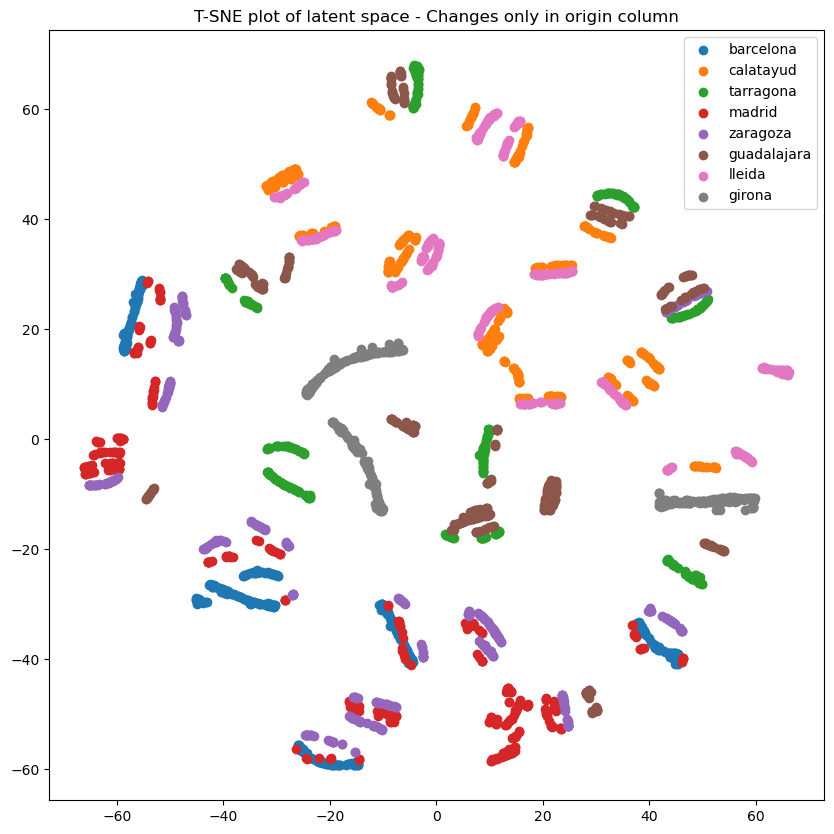

In [21]:
tsne = TSNE(n_components=2, random_state=15)
tsne_latent_space = tsne.fit_transform(latent_space)

# Scatter plot tsne_latent_space
plt.figure(figsize=(10, 10))
plt.title("T-SNE plot of latent space - Changes only in origin column")

origin_values = set(locked_embedding.df['origin'].values)
for i, origin in enumerate(origin_values):
    plt.scatter(tsne_latent_space[locked_embedding.df['origin'] == origin, 0],
                tsne_latent_space[locked_embedding.df['origin'] == origin, 1],
                label=origin)
plt.legend()
plt.savefig(SAVE_PATH + "tsne_origin", dpi=300)
plt.show()

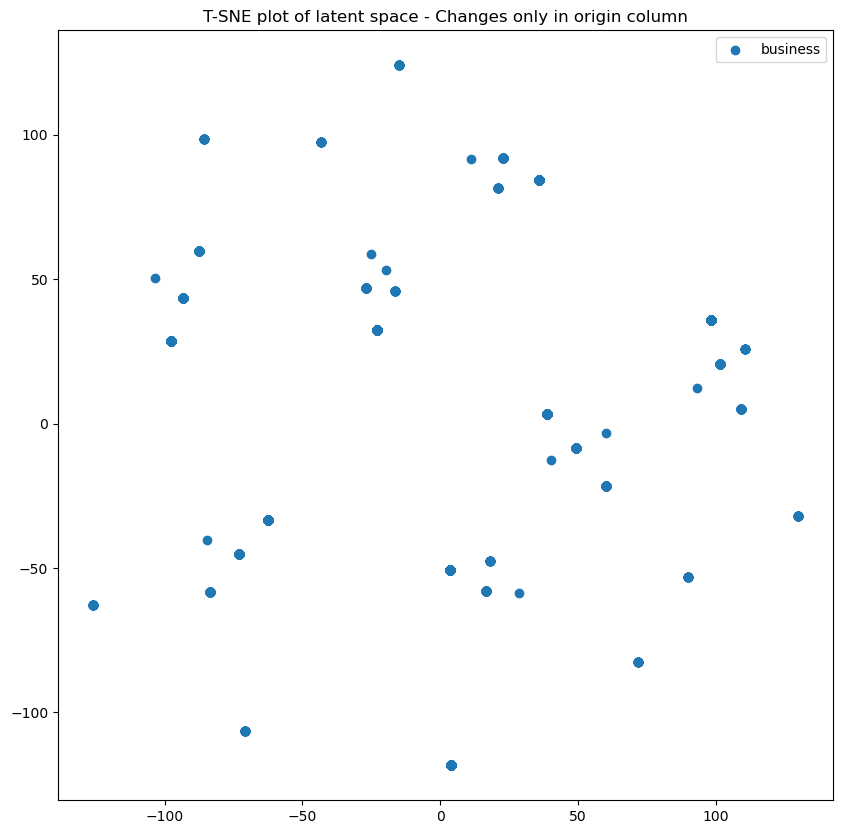

In [75]:
plt.figure(figsize=(10, 10))
plt.title("T-SNE plot of latent space - Changes only in origin column")

user_pattern_values = set(locked_embedding.df['user_pattern'].values)
for i, user_pattern in enumerate(user_pattern_values):
    plt.scatter(tsne_latent_space[locked_embedding.df['user_pattern'] == user_pattern, 0],
                tsne_latent_space[locked_embedding.df['user_pattern'] == user_pattern, 1],
                label=user_pattern)
plt.legend()
plt.show()

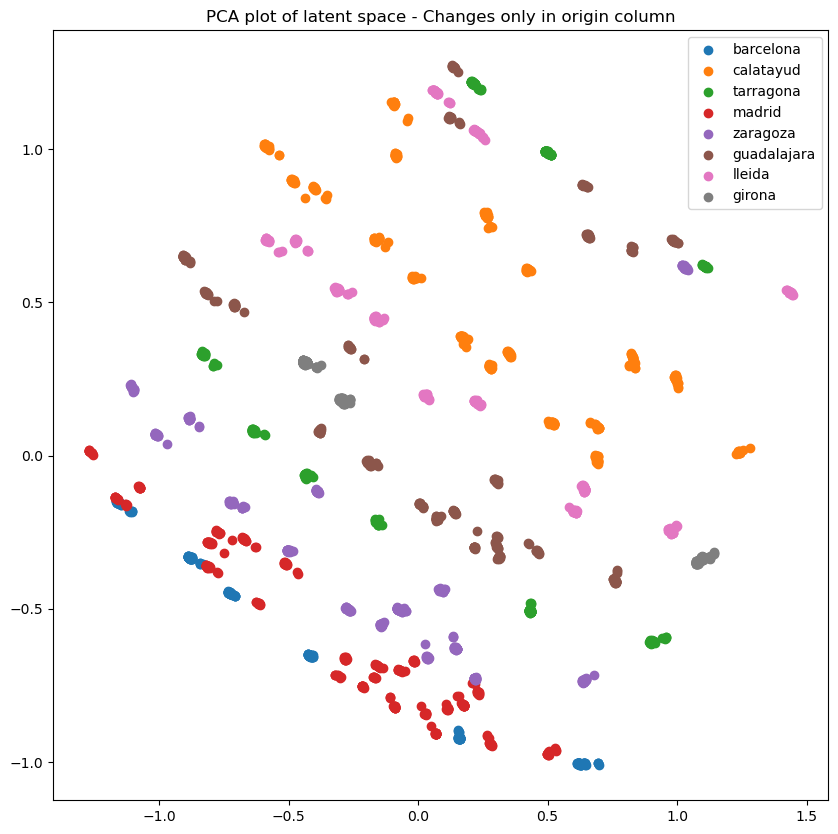

In [22]:
# PCA on latent space to analyze relationship between latent factors and input variables

pca = PCA(n_components=2)
pca_latent_space = pca.fit_transform(latent_space)

# Scatter plot pca_latent_space with legend of origin
plt.figure(figsize=(10, 10))
plt.title("PCA plot of latent space - Changes only in origin column")

for i, origin in enumerate(origin_values):
    plt.scatter(pca_latent_space[locked_embedding.df['origin'] == origin, 0],
                pca_latent_space[locked_embedding.df['origin'] == origin, 1],
                label=origin)

plt.legend()
plt.savefig(SAVE_PATH + "pca_", dpi=300)
plt.show()

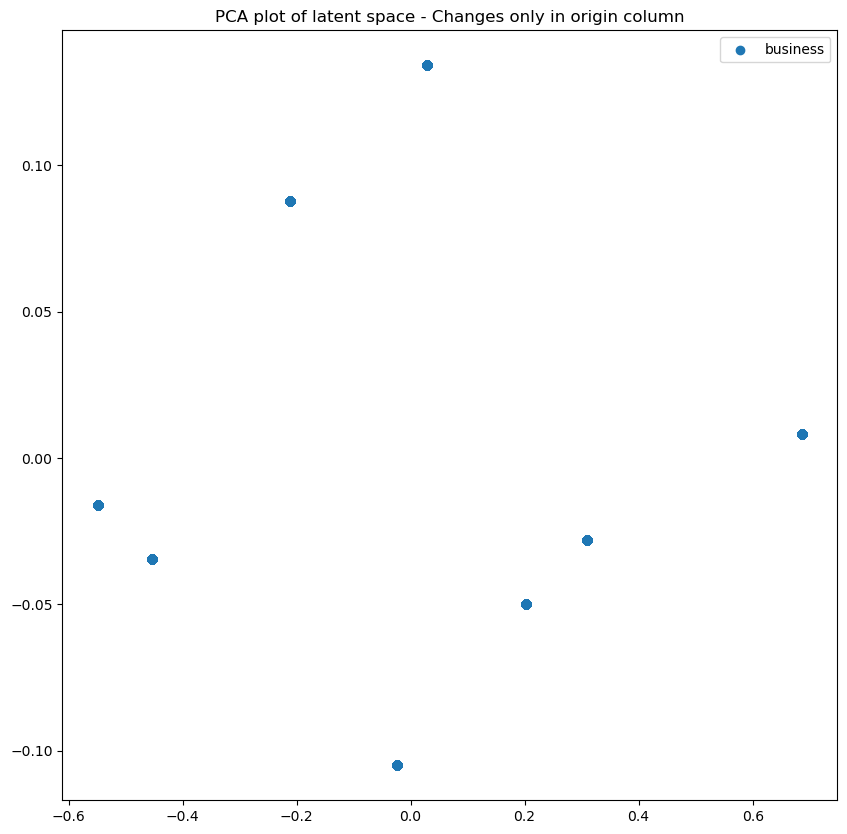

In [74]:
# PCA on latent space to analyze relationship between latent factors and input variables

pca = PCA(n_components=2)
pca_latent_space = pca.fit_transform(latent_space)

# Scatter plot pca_latent_space with legend of origin
plt.figure(figsize=(10, 10))
plt.title("PCA plot of latent space - Changes only in origin column")

for i, user_pattern in enumerate(user_pattern_values):
    plt.scatter(pca_latent_space[locked_embedding.df['user_pattern'] == user_pattern, 0],
                pca_latent_space[locked_embedding.df['user_pattern'] == user_pattern, 1],
                label=user_pattern)

plt.legend()
plt.show()

In [76]:
# Calculate Pearson correlation
pearson_corr = []
p_values_pearson = []
for i in range(latent_dim):
    correlation, p_value = pearsonr(latent_space[:, i], test_embedding.df_embedding['time'])
    pearson_corr.append(correlation)
    p_values_pearson.append(p_value)

# Calculate Spearman correlation
spearman_corr = []
p_values_spearman = []
for i in range(latent_dim):
    correlation, p_value = spearmanr(latent_space[:, i], test_embedding.df_embedding['time'])
    spearman_corr.append(correlation)
    p_values_spearman.append(p_value)

# Create dataframe with results
resultados_correlacion = pd.DataFrame({'Latent factor': range(1, 6),
                                      'Pearson correlation': pearson_corr,
                                      'Pearson p-value': p_values_pearson,
                                      'Spearman correlation': spearman_corr,
                                      'Spearman p-valus': p_values_spearman})

# Print results
display(resultados_correlacion)
print()

,Latent factor,Pearson correlation,Pearson p-value,Spearman correlation,Spearman p-valus
0,1,-0.020351,0.265133,-0.018771,0.304040
1,2,0.020087,0.271380,0.018176,0.319631
2,3,0.008296,0.649676,0.004417,0.808894
3,4,-0.004559,0.802910,-0.004893,0.788798
4,5,-0.003577,0.844732,0.000318,0.986124


In [77]:
df_test = test_embedding.df.copy()
df_test.drop(columns=['arrival_date'], inplace=True)
df_test['time'] = df_test['time'].apply(lambda x: np.float32(int(datetime.timedelta(hours=x.hour, minutes=x.minute, seconds=x.second).total_seconds())
))
df_test = pd.get_dummies(df_test, columns=['origin', 'destination', 'user_pattern', 'week_day', 'month'])

# df_test to numpy array
df_test = df_test.to_numpy()

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_test,
                                                    latent_space,
                                                    test_size=0.2,
                                                    random_state=0)

# Train MLPRegressor
regressor = MLPRegressor(hidden_layer_sizes=(100, 100, 100),
                         activation='relu',
                         solver='adam',
                         max_iter=1000,
                         random_state=0).fit(X_train, y_train)

# Evaluate MLPRegressor
print(f"Train score: {regressor.score(X_train, y_train)}")
print(f"Test score: {regressor.score(X_test, y_test)}")

Train score: -1615060.8584698683
Test score: -1575013.2950884283
